In [35]:
from braket.tracking import Tracker
t = Tracker().start()

In [36]:
from qiskit_braket_provider import AWSBraketProvider
provider = AWSBraketProvider()
provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

In [37]:
provider.backends(statuses=["ONLINE"], types=["QPU"])

[BraketBackend[Forte 1], BraketBackend[Lucy]]

In [38]:
backend = provider.get_backend("TN1")

In [39]:
print(backend)

BraketBackend[TN1]


In [40]:
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendSampler
from qiskit.circuit.library import QAOAAnsatz

from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
import matplotlib.pyplot as plt
import time
from qiskit import QuantumCircuit, transpile, assemble

In [41]:
#Number of buses and lines
num_buses = 14
num_lines = 20

#incidence matrix
incidence_matrix = np.zeros((num_buses, num_lines))

#transmission lines
lines = [(1, 2), (1, 5), (2,3), (2,4), (2,5), (3,4),(4,5), (4,7), (4,9), (5,6), (6,11)
        ,(6,12), (6,13), (7,8), (7,9), (9,10), (9,14), (10,11), (12,13), (13,14)]

for line_idx, (from_bus, to_bus) in enumerate(lines):
    incidence_matrix[from_bus - 1, line_idx] = 1  # "from" bus
    incidence_matrix[to_bus - 1, line_idx] = -1   # "to" bus

In [42]:
destinations = [11, 12, 13]
demands = {12: 40, 13: 30, 14: 30}
line_capacities = {(1, 2): 100, (1, 5): 100, (2, 3): 100, (2, 4): 100, (2, 5): 100,
                   (3, 4): 100, (4, 5): 100, (4, 7): 100, (4, 9): 100, (5, 6): 100,
                   (6, 11): 100, (6, 12): 100, (6, 13): 100, (7, 8): 100, (7, 9): 100,
                   (9, 10): 100, (9, 14): 100, (10, 11): 100, (12, 13): 100, (14, 13): 100}

In [43]:
num_buses = num_buses
Generator_number = [1,2,3,4,5]
num_generator = len(Generator_number)
#admittance matrix
Y = np.zeros((num_buses, num_buses), dtype=complex)

# Specified line parameters (example values)
specified_lines = lines
specified_R = [0.01938, 0.05403, 0.04699, 0.05811, 0.05695, 0.06701, 0.01335, 0, 0, 0, 0.09498, 0.12291
              ,0.06615, 0, 0, 0.03181, 0.12711, 0.08205, 0.22092, 0.17093]
specified_X = [0.05917, 0.22304, 0.19797, 0.17632, 0.17388, 0.17103, 0.04211, 0.20912, 0.55618, 0.25202
              ,0.19890, 0.25581, 0.13027, 0.17615, 0.11001, 0.0845, 0.27038, 0.19207, 0.19988, 0.34802]
specified_B = [0.0264, 0.0219, 0.0187, 0.0246, 0.017, 0.0173, 0.0064, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
               , 0, 0]

for (i, j), R_ij, X_ij, B_ij in zip(specified_lines, specified_R, specified_X, specified_B):
    Z_ij = R_ij + 1j * X_ij
    Y_ch_ij = 1j * B_ij
    Y[i-1, i-1] += Y_ch_ij
    Y[i-1, j-1] -= 1 / Z_ij
    Y[j-1, i-1] = np.conj(Y[i-1, j-1])

In [44]:
line_resistances = {lines[i]: specified_R[i] for i in range(len(lines))}
line_costs = {(1, 2): 20, (1, 5): 10, (2, 3): 50, (2, 4): 10, (2, 5): 5,
              (3, 4): 45, (4, 5): 20, (4, 7): 20, (4, 9): 40, (5, 6): 10,
              (6, 11): 10, (6, 12): 20, (6, 13): 10, (7, 8): 30, (7, 9): 20,
              (9, 10): 20, (9, 14): 10, (10, 11): 10, (12, 13): 10, (13, 14): 20}

In [45]:
G = np.real(Y)
B = np.imag(Y)

In [46]:
V_magnitudes = [1.06, 1.045, 1.01, 1.01767, 1.01951, 1.07000, 1.06152, 1.09000, 1.05593, 1.05099, 1.05691
               ,1.05519, 1.05038, 1.03558]  # Example magnitudes for buses 1, 2, 3
theta_angles_degrees = [0, -4.9826, -12.725, -10.3128, -8.7738, -14.2209, -13.3596, -13.3596, -14.9385
                       ,-15.0972, -14.7906, -15.0755, -15.1562, -16.0336]  # Example phase angles in degrees for buses 1, 2, 3

theta_angles = np.deg2rad(theta_angles_degrees)

real_v = np.zeros(len(V_magnitudes))
imaginary_v = np.zeros(len(V_magnitudes))

for i in range(len(V_magnitudes)):
    real_v[i] = V_magnitudes[i] * np.cos(theta_angles[i])
    imaginary_v[i] = V_magnitudes[i] * np.sin(theta_angles[i])

In [47]:
theta_ij_matrix = np.zeros((num_buses, num_buses))

In [48]:
PD = [30, 100, 120, 120]
demand = sum(PD)

bounds_PG = [(0,332.4), (0, 140), (0, 100), (0, 100), (0, 100)]

bounds_Vi = [(1.0388, 1.0812), (1.0241, 1.0658), (0.9898, 1.0302), (0.9973, 1.0380), (0.9991, 1.03990), (1.0486, 1.0914), (1.0402, 1.0827), (1.0682, 1.1118), (1.0348, 1.0770), (1.0299, 1.0720), (1.0357, 1.0780), (1.0340, 1.0762), (1.0293, 1.0713), (1.0148, 1.0562)]
gi_up = [50, 20, 10, 10, 10]
gi_down = [-50, -20, -10, -10, -10]
a = np.array([0.043, 0.25, 0.01, 0.01, 0.01])
a = a.astype(int)
b = np.array([20, 20, 40, 40, 40])
b = b.astype(int)
c = np.array([0, 0, 0, 0, 0])
c = c.astype(int)

In [53]:
sampler = BackendSampler(
    backend=backend,
    skip_transpilation=False,
    options={"shots": 200}
)

In [54]:
def main(N, total_demand, mode):
    start_time = time.time()
    def harray(N):
        arr = np.zeros(num_generator)
        for i in range(num_generator):
            arr[i] = np.round((bounds_PG[i][1] - bounds_PG[i][0])/N)
        return arr
    
    mdl = Model("DCOPF")
    Nlim = range(0, N)
    z = [[mdl.binary_var(name=f'z_{i}_{k}') for k in Nlim] for i in range(num_generator)]
    v = [mdl.binary_var(name=f'v_{i}') for i in range(num_generator)]
    
    
    def pi(i):
        h_val =  harray(N)[i]
        ret = sum((k) * h_val * z[i][k]  for k in Nlim)  
        ret = ret + bounds_PG[i][0]
        return ret
    
    
    def cost():
        cost = sum((c[i] * (1-v[i]) + b[i] * pi(i) + a[i] * pi(i)*pi(i)) for i in range(num_generator))
        return cost
    
    
    mdl.minimize(cost())
    mdl.add_constraint(sum(pi(i) for i in range(num_generator)) == np.round(total_demand))
    for i in range(num_generator):
        mdl.add_constraint(sum(z[i][k]  for k in range(0, N)) + v[i]== 1)
    #print(mdl.export_to_string())
    
    qp = from_docplex_mp(mdl)
    #print(type(qp))
    #print()
    #print(mdl.prettyprint())
    
    qp_to_qubo = QuadraticProgramToQubo()
    qubo = qp_to_qubo.convert(qp)
    
    hamiltonian, offset = qubo.to_ising()
    #print("offset: {}".format(offset))
    #print("operator:")
    #print(hamiltonian)

    algorithm_globals.random_seed = 10598
    qaoa_mes = QAOA(sampler=sampler, reps =1, optimizer=COBYLA(), initial_point=[0.0, 0.0])
    exact_mes = NumPyMinimumEigensolver()

    if mode == "classical":
        exact = MinimumEigenOptimizer(exact_mes)
        result = exact.solve(qubo)
        print("!!!This is Classical result!!!")

    elif mode == "quantum":
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(qubo)
        print("!!!This is Quantum result!!!")
    else:
        print("enter a valid mode!!!")
        
    Nlim = range(0,N)
    
    exact_result = result

    k = 0
    i = 0
    Nlim = range(0,N)
    zik = np.zeros((num_generator, len(Nlim)))
    for j in range(num_generator * len(Nlim)):
        zik[i][k] = exact_result[j]
        if k == Nlim[-1]:
            i += 1 
            k = 0
        else:
            k += 1
    
    fpi = np.zeros((num_generator, len(Nlim)))
    def final_pi(l,n):       
        h_val =  harray(N)[l]
        return (n) * h_val *zik[l][n]
    
    
    for i in range(num_generator):
        for j in Nlim:
            fpi[i][j] = final_pi(i,j)
    
    result_pi = np.zeros(num_generator)
    for i in range(num_generator):
        result_pi[i] = sum(fpi[i][k] for k in Nlim)
    
    generator_status = np.empty(num_generator, dtype=object)
    
    for i in range(num_generator):
        if result_pi[i] == 0:
            generator_status[i] = "inactive"
        else:
            generator_status[i] = "active"
            
    active_generators = [i + 1 for i, status in enumerate(generator_status) if status == 'active']
    print("generator status", generator_status)
    
    qp2 = QuadraticProgram()

    # Set to keep track of added variables
    added_variables = set()
    
    # Add binary variables
    for (i, j) in lines:
        variable_name = f'y_{i}_{j}'
        if variable_name not in added_variables:
            qp2.binary_var(variable_name)
            added_variables.add(variable_name)
    
    # Add the objective function: minimize total cost + total power losses
    for (i, j) in lines:
        variable_name = f'y_{i}_{j}'
        if variable_name not in added_variables:
            qp2.minimize(line_costs[(i, j)] * qp.binary_var(variable_name))
            added_variables.add(variable_name)
    
    # Add flow conservation constraints
    for g in Generator_number + destinations:
        constraint_vars = {f'y_{i}_{j}': 1 for (i, j) in lines if i == g}
        qp2.linear_constraint(linear=constraint_vars, sense='==', rhs=1)

    #qp2.linear_constraint(linear={'y_1_2': 1}, sense='==', rhs=0)
    
    # Add demand satisfaction constraints considering losses
    for dest in destinations:
        for (i, j) in lines:
            if j == dest:
                variable_name = f'y_{i}_{j}'
                if variable_name not in added_variables:
                    qp2.linear_constraint(linear={variable_name: line_capacities[(i, j)] - line_resistances[lines.index((i, j))] * qp2.binary_var(variable_name)},
                                         sense='>=',
                                         rhs=demands[dest])

    
    # Convert to QUBO
    converter = QuadraticProgramToQubo()
    qubo2 = converter.convert(qp2)
    
    if mode == "classical":
        exact = MinimumEigenOptimizer(exact_mes)
        topology = exact.solve(qubo2)
        print("!!!This is Classical result!!!")

    elif mode == "quantum":
        qaoa2 = MinimumEigenOptimizer(qaoa_mes)
        topology = qaoa.solve(qubo2)
        print("!!!This is Quantum result!!!")
    else:
        print("enter a valid mode!!!")


    # Extract the values of binary variables
    binary_solution = topology.x

    
    # Initialize total cost
    total_line_cost = 0
    
    # List to store active lines
    active_lines = []
    
    # Iterate through binary solution and check for active lines
    for idx, val in enumerate(binary_solution):
        if val == 1:
            active_lines.append(lines[idx])
            total_line_cost += line_costs[lines[idx]]
    
    # Print active lines
    print("Active Lines:")
    for line in active_lines:
        print(line)


    
    def demand():
        return sum(PDi[i] for i in range(num_generator))
    for i in range(num_generator):
        print("The power generated by power plant", i + 1, "is", result_pi[i],"MWh")
    print("total power generated is ", sum(result_pi[i] for i in range(num_generator)), "MWh, and the demand is", total_demand,"MWh")
    
    def total_cost():
        return sum(a[i] *  result_pi[i]**2 + b[i] *  result_pi[i] + c[i] for i in range(num_generator))
        
    print("the total cost is", total_cost() + total_line_cost)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {np.round(elapsed_time,2)} seconds")    
    
    plt.bar(Generator_number, result_pi)
    plt.xticks(Generator_number)
    plt.xlabel('Generator')
    plt.ylabel('Power Generated (MWh)')
    plt.title('Power Generated by Each Power Plant')
    plt.show()

    return 

!!!This is Classical result!!!
generator status ['active' 'inactive' 'active' 'active' 'active']
!!!This is Classical result!!!
Active Lines:
(1, 2)
(2, 4)
(3, 4)
(4, 7)
(5, 6)
(6, 11)
(7, 8)
(7, 9)
(12, 13)
(13, 14)
The power generated by power plant 1 is 166.0 MWh
The power generated by power plant 2 is 0.0 MWh
The power generated by power plant 3 is 50.0 MWh
The power generated by power plant 4 is 50.0 MWh
The power generated by power plant 5 is 50.0 MWh
total power generated is  316.0 MWh, and the demand is 323 MWh
the total cost is 9515.0
Time taken: 1.51 seconds


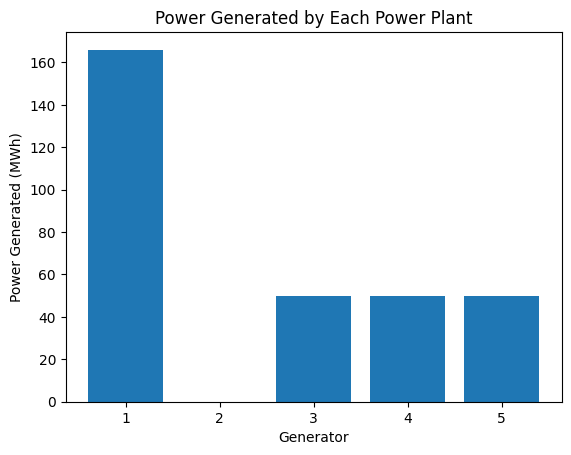

In [58]:
total_demand = 323 #fix the demand from the generators
N = 2 # number of bins
mode = "classical" #quantum for quantum solver, classical for classical solver
main(N, total_demand, mode)

In [56]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/tn1': {'shots': 17500, 'tasks': {'COMPLETED': 118}, 'execution_duration': datetime.timedelta(seconds=970, microseconds=252000), 'billed_execution_duration': datetime.timedelta(seconds=1041, microseconds=411000)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 4.77 USD
